# CS4487 - Tutorial 3
## Gender Classification from Face Images

In this tutorial you will train a classifier to predict whether a face image is male or female.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


## 1. Loading Data and Pre-processing
We first need to load the images.  Download `photos-bw.zip` and put it in the same directory as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [2]:
imgdata = []
genders = []

# load the zip file
filename = 'photos-bw.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "photos-bw/*.png"):
        print("loading", name)
        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        img = matplotlib.image.imread(myfile)
        myfile.close()
        
        # append to data
        imgdata.append(img)
        genders.append( int(name[len("photos-bw/")] == 'm') )  # 0 is female, 1 is male
        
zfile.close()
imgsize = img.shape
print("DONE: loaded {} images".format(len(imgdata)))

loading photos-bw/f-039-01.png
loading photos-bw/f-040-01.png
loading photos-bw/f-041-01.png
loading photos-bw/f-042-01.png
loading photos-bw/f-043-01.png
loading photos-bw/f1-001-0.png
loading photos-bw/f1-002-0.png
loading photos-bw/f1-003-0.png
loading photos-bw/f1-004-0.png
loading photos-bw/f1-005-0.png
loading photos-bw/f1-006-0.png
loading photos-bw/f1-007-0.png
loading photos-bw/f1-008-0.png
loading photos-bw/f1-009-0.png
loading photos-bw/f1-010-0.png
loading photos-bw/f1-011-0.png
loading photos-bw/f1-012-0.png
loading photos-bw/f1-013-0.png
loading photos-bw/f1-014-0.png
loading photos-bw/f1-015-0.png
loading photos-bw/m-063-01.png
loading photos-bw/m-064-01.png
loading photos-bw/m-065-01.png
loading photos-bw/m-067-01.png
loading photos-bw/m-069-01.png
loading photos-bw/m-070-01.png
loading photos-bw/m-073-01.png
loading photos-bw/m-074-01.png
loading photos-bw/m-075-01.png
loading photos-bw/m-077-01.png
loading photos-bw/m-083-01.png
loading photos-bw/m-085-01.png
loading 

Each image is a 45x40 array of pixel values.  Run the below code to show an example:

(45, 40)


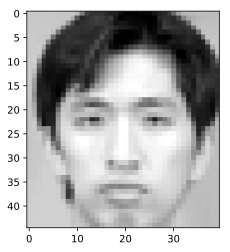

In [3]:
print(img.shape)
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.show()

Run the below code to show all the images!

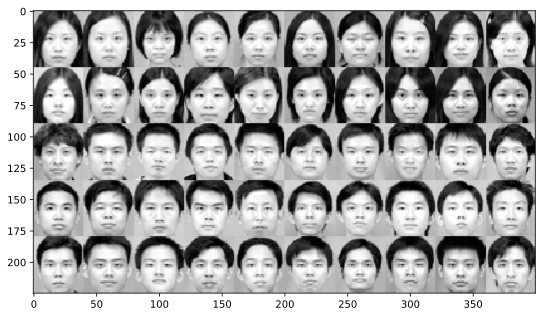

In [4]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [5]:
X = empty((50, prod(imgdata[0].shape))) # create empty array
for i,img in enumerate(imgdata):
    X[i,:] = ravel(img)           # for each image, turn it into a vector
Y = asarray(genders)  # convert list to numpy array
print(X.shape)
print(Y.shape)

(50, 1800)
(50,)


Next we will shift the pixel values so that gray is 0.0, black is -0.5 and white is 0.5.

In [6]:
print("Before: min={}, max={}".format(X.min(), X.max()))
X -= 0.5
print("After:  min={}, max={}".format(X.min(), X.max()))

Before: min=0.0, max=1.0
After:  min=-0.5, max=0.5


Finally, split the dataset into a training set and testing set. We select 80% for training and 20% for testing.

In [7]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(X, Y, 
  train_size=0.80, test_size=0.20, random_state=4487)

print(trainX.shape)
print(testX.shape)

(40, 1800)
(10, 1800)


# 2. Logistic Regression
Train a logistic regression classifier.  Use cross-validation to select the best C parameter.

In [8]:
### INSERT YOUR CODE HERE
logreg = linear_model.LogisticRegressionCV(Cs=logspace(-4,4,20), cv=5)
logreg.fit(trainX,trainY)

print("w =", logreg.coef_)
print("b =", logreg.intercept_)
print("C = ", logreg.C_)

w = [[0.00035113 0.00040657 0.00049916 ... 0.01334931 0.01042594 0.01006051]]
b = [-0.07932328]
C =  [0.01274275]


Use the learned model to predict the genders for the training and testing data. What is the accuracy on the training set? What is the accuracy on the testing set?

In [9]:
### INSERT YOUR CODE HERE
predYtrain = logreg.predict(trainX)
predY = logreg.predict(testX)
acc      = metrics.accuracy_score(trainY, predYtrain)
print("train accuracy =", acc)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy =", acc)

train accuracy = 0.9
test accuracy = 0.8


### Analyzing the classifier
Run the below code to show the hyperplane parameter $\mathbf{w}$ as an image.  

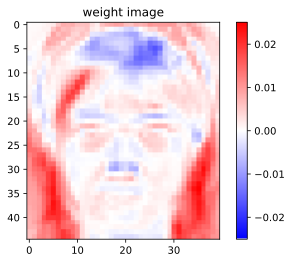

In [10]:
# logreg is the learned logistic regression model
wimg = logreg.coef_.reshape(imgsize)      # get the w and reshape into an image
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#FFFFFF", "#FF0000"])
mm = max(wimg.max(), -wimg.min())
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("weight image")
plt.show()

Recall that the classifier prediction is based on the sign of the function $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+b = \sum_{i=1}^P w_ix_i + b$.  Here each $x_i$ is a pixel in the face image, and $w_i$ is the corresponding weight.  Hence, the function is multiplying face image by the weight image, and then summing over all pixels.

In order for $f(\mathbf{x})$ to be positive, then the positive values of the weight image (red regions) should match the positive values in the face image (white pixels), and the negative values of the weight image (blue regions) should be matched with negative values in the face image (black pixels).

Hence, we can have the following interpretation:
<table>
<tr><th>Class</th><th>red regions (positive weights)</th><th>blue regions (negative weights)</th><th>white regions (weights near 0)</th></tr>
<tr><td>+1 class (male)</td><td>white pixels in face image</td><td>black pixels in face image</td><td>region not important</td></tr>
<tr><td>-1 class (female)</td><td>black pixels in face image</td><td>white pixels in face image</td><td>region not important</td></tr>
</table>
  
_Looking at the weight image, what parts of the face image is the classifier looking at to determine the gender?  Does it make sense?_

- As seen from the image, the classifier tries to look at discernible features. For example, it can be seen that the bottom corners are red, this is because women generally have long hair, so there are more black pixels in that posistion and males generally have short hair, hence have more white pixels in that region. This region is given more importance as long hair is one of the primary characteristic for classifying women.

Now let's look at the misclassified faces in the test set.  Run the below code to show the misclassifed and correctly classified faces.

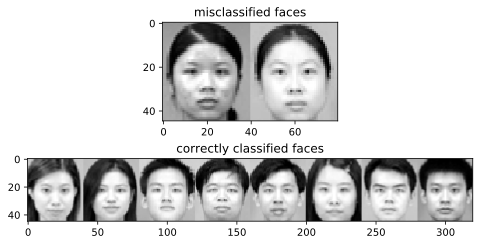

In [11]:
# predYtest are the class predictions on the test set.

# find misclassified test images
inds = where(predY != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predY == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()

_Why did the classifier make incorrect predictions on the misclassified faces?_
- The reason this images were misclassified is that the women in the pictures have combed their hair behind their heads. Hence, the classifier assumes that it is a picture of a person with short hair.


# 3. Support Vector Machine
Now train a support vector machine (SVM) on the same training and testing data.  Use cross-validation to select the best $C$ parameter.

In [12]:
# fit the SVM using all the data and the best C  
clf = svm.SVC(kernel='linear', C=2)
clf.fit(trainX, trainY)

# get line parameters
w = clf.coef_[0]
b = clf.intercept_[0]
print(w)
print(b)
clf.support_

[ 3.03327018e-05  8.44951519e-04  9.07367949e-04 ...  1.02904780e-03
 -3.18110924e-03  4.76279322e-03]
-1.276007373771445


array([ 1,  3, 12, 22, 25,  2,  4,  7, 13, 15, 17, 26, 27, 28, 30, 35])

In [13]:

paramgrid = {'C': logspace(-3,3,13)}
print(paramgrid)

# setup the cross-validation object
# pass the SVM object, parameter grid, and number of CV folds
# set number of parallel jobs to -1 (use all cores)
svmcv = model_selection.GridSearchCV(svm.SVC(kernel='linear'), paramgrid, cv=7,
                                     n_jobs=-1, verbose=True)

# run cross-validation (train for each split)
svmcv.fit(trainX, trainY);

{'C': array([1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03])}
Fitting 7 folds for each of 13 candidates, totalling 91 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    2.8s finished


Calculate the training and test accuracy for the SVM classifier.

In [14]:
print(svmcv.best_params_)
print(svmcv.best_score_)
print(svmcv.best_estimator_)

{'C': 0.01}
0.9
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [15]:
predYtrain = svmcv.predict(trainX)
acc      = metrics.accuracy_score(trainY, predYtrain)
print("train accuracy =", acc)
predY = svmcv.predict(testX)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy = " + str(acc))

train accuracy = 0.925
test accuracy = 0.8


Similar to before, plot an image of the hyperplane parameters $w$, and view the misclassified and correctly classified test images.

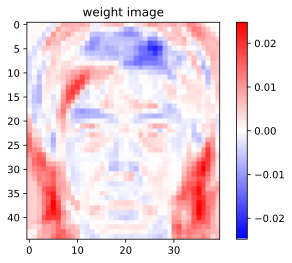

In [16]:
wimg = svmcv.best_estimator_.coef_.reshape(imgsize)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#FFFFFF", "#FF0000"])
mm = max(wimg.max(), -wimg.min())
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("weight image")
plt.show()

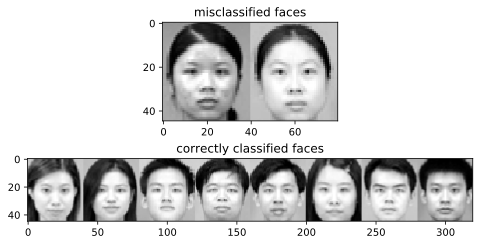

In [17]:
# predYtest are the class predictions on the test set.

# find misclassified test images
inds = where(predY != testY) # get indices of misclassified test images
# make a montage
badimgs = image_montage(testX[inds], imsize=imgsize)

# find correctly classified test images
inds = where(predY == testY)
goodimgs = image_montage(testX[inds], imsize=imgsize)
    
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.imshow(badimgs, cmap='gray', interpolation='nearest')
plt.title('misclassified faces')
plt.subplot(2,1,2)
plt.imshow(goodimgs, cmap='gray', interpolation='nearest')
plt.title('correctly classified faces')
plt.show()

_Are there any differences between the $w$ for logistic regressiona and the $w$ for SVM?  Is there any interpretation for the differences?_

- The weights around the evebrows and the weights on the forehead are more negative. The SVM tries to classify Male faces based on thicker eyebrows. There also appears to be lesser pixels with weights close to 0, more spots with slightly coloured portion and lesser pixels with white portions(weights = 0). The reason for this gradient of pixels is because the differences in the way SVM and LR work. Since LR is a probabilistic method, it only takes in consideration features unique to each class. SVM on the other hand tries to find the largest difference between points, so it tries to make sure that each point or feature is classifiable  